# Classification of Win/Loss using Season Averages

This peaked with a .605 using SVC. 

In [1]:
#Load

from bs4 import BeautifulSoup
import time
import requests     # to get images
import shutil       # to save files locally
import datetime
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import sqlite3
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, f1_score, make_scorer, recall_score
from sklearn.linear_model import LogisticRegression
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.pyplot import figure
from bs4 import BeautifulSoup
import time
import datetime
from scipy.stats import norm
import xgboost
from xgboost import XGBClassifier
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE, ADASYN
import random
from random import randint
from sklearn.datasets import *
from IPython.display import Image, display_svg, SVG
import os
from dtreeviz.trees import *
from sklearn.tree import plot_tree

In [2]:
df = pd.read_excel('data_outputs\\advancedboxes_5years_XCEL_EDIT.xlsx')

In [3]:
df.head()

,Unnamed: 0,Team,Match Up,GameDate,W/L,MIN,OffRtg,DefRtg,NetRtg,AST%,...,avgOPP_AST/TO,avgOPP_Ast_ratio,avgOPP_OREB%,avgOPP_DREB%,avgOPP_REB%,avgOPP_TOV%,avgOPP_eFG%,avgOPP_TS%,avgOPP_PACE,avgOPP_PIE
0,1,CLE,CLE vs. MIL,04/10/2022,W,48,127.9,109.5,18.4,76.5,...,1.83,18.39,27.76,72.70,50.77,14.92,53.61,57.03,96.53,51.99
1,2,LAL,LAL @ DEN,04/10/2022,W,53,129.2,122.6,6.6,59.1,...,1.82,17.29,25.51,72.28,49.03,14.23,53.72,56.69,100.30,48.37
2,3,UTA,UTA @ POR,04/10/2022,W,48,112.1,81.6,30.5,62.2,...,1.80,16.72,29.56,73.90,52.29,14.24,55.81,59.15,97.43,52.46
3,4,SAC,SAC @ PHX,04/10/2022,W,48,117.2,110.1,7.1,65.0,...,1.78,17.26,25.52,71.85,48.43,14.07,52.56,56.17,100.02,46.86
4,5,DAL,DAL vs. SAS,04/10/2022,W,48,130.0,120.0,10.0,73.9,...,2.06,17.67,25.77,73.32,49.57,12.96,53.97,57.30,95.49,51.17


In [4]:
df['win?'] = np.where(df['W/L'] == 'W', 1, 0)
df

,Unnamed: 0,Team,Match Up,GameDate,W/L,MIN,OffRtg,DefRtg,NetRtg,AST%,...,avgOPP_Ast_ratio,avgOPP_OREB%,avgOPP_DREB%,avgOPP_REB%,avgOPP_TOV%,avgOPP_eFG%,avgOPP_TS%,avgOPP_PACE,avgOPP_PIE,win?
0,1,CLE,CLE vs. MIL,04/10/2022,W,48,127.9,109.5,18.4,76.5,...,18.39,27.76,72.70,50.77,14.92,53.61,57.03,96.53,51.99,1
1,2,LAL,LAL @ DEN,04/10/2022,W,53,129.2,122.6,6.6,59.1,...,17.29,25.51,72.28,49.03,14.23,53.72,56.69,100.30,48.37,1
2,3,UTA,UTA @ POR,04/10/2022,W,48,112.1,81.6,30.5,62.2,...,16.72,29.56,73.90,52.29,14.24,55.81,59.15,97.43,52.46,1
3,4,SAC,SAC @ PHX,04/10/2022,W,48,117.2,110.1,7.1,65.0,...,17.26,25.52,71.85,48.43,14.07,52.56,56.17,100.02,46.86,1
4,5,DAL,DAL vs. SAS,04/10/2022,W,48,130.0,120.0,10.0,73.9,...,17.67,25.77,73.32,49.57,12.96,53.97,57.30,95.49,51.17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11653,11654,IND,IND vs. BKN,10/18/2017,W,48,119.7,113.9,5.7,54.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
11654,11655,CLE,CLE vs. BOS,10/17/2017,W,48,104.1,100.0,4.1,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
11655,11656,BOS,BOS @ CLE,10/17/2017,L,48,100.0,104.1,-4.1,66.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
11656,11657,HOU,HOU @ GSW,10/17/2017,W,48,120.8,119.8,1.0,59.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [5]:
df = df.dropna()
df

,Unnamed: 0,Team,Match Up,GameDate,W/L,MIN,OffRtg,DefRtg,NetRtg,AST%,...,avgOPP_Ast_ratio,avgOPP_OREB%,avgOPP_DREB%,avgOPP_REB%,avgOPP_TOV%,avgOPP_eFG%,avgOPP_TS%,avgOPP_PACE,avgOPP_PIE,win?
0,1,CLE,CLE vs. MIL,04/10/2022,W,48,127.9,109.5,18.4,76.5,...,18.39,27.76,72.70,50.77,14.92,53.61,57.03,96.53,51.99,1
1,2,LAL,LAL @ DEN,04/10/2022,W,53,129.2,122.6,6.6,59.1,...,17.29,25.51,72.28,49.03,14.23,53.72,56.69,100.30,48.37,1
2,3,UTA,UTA @ POR,04/10/2022,W,48,112.1,81.6,30.5,62.2,...,16.72,29.56,73.90,52.29,14.24,55.81,59.15,97.43,52.46,1
3,4,SAC,SAC @ PHX,04/10/2022,W,48,117.2,110.1,7.1,65.0,...,17.26,25.52,71.85,48.43,14.07,52.56,56.17,100.02,46.86,1
4,5,DAL,DAL vs. SAS,04/10/2022,W,48,130.0,120.0,10.0,73.9,...,17.67,25.77,73.32,49.57,12.96,53.97,57.30,95.49,51.17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9253,9254,MEM,MEM vs. DET,04/08/2018,W,48,131.3,120.6,10.7,75.0,...,16.39,27.19,72.71,49.39,15.64,49.80,53.77,95.52,45.87,1
9254,9255,PHX,PHX vs. GSW,04/08/2018,L,48,98.0,114.7,-16.7,61.5,...,15.46,26.92,72.52,49.20,15.54,49.48,53.24,101.21,43.93,0
9255,9256,ORL,ORL @ TOR,04/08/2018,L,48,104.1,114.3,-10.2,59.5,...,17.39,24.87,71.48,47.98,14.67,51.42,54.66,98.55,47.22,0
9256,9257,GSW,GSW @ PHX,04/08/2018,W,48,114.7,98.0,16.7,57.4,...,20.85,24.20,71.38,49.90,15.35,57.11,60.50,100.33,55.61,1


## 1. Project Overview:
Solve for single game NBA wins

## Define Target Variable

In this case, the target variable is whether or not an individual had heart disease. 

In [6]:
target = ['win?']

## Define Scoring Metric

options: https://scikit-learn.org/stable/modules/model_evaluation.html


Accuracy!


In [7]:
class_metric = 'accuracy'

In [8]:
# Describe Data
df.describe().round(2)

,Unnamed: 0,MIN,OffRtg,DefRtg,NetRtg,AST%,AST/TO,ASTRatio,OREB%,DREB%,...,avgOPP_Ast_ratio,avgOPP_OREB%,avgOPP_DREB%,avgOPP_REB%,avgOPP_TOV%,avgOPP_eFG%,avgOPP_TS%,avgOPP_PACE,avgOPP_PIE,win?
count,9258.00,9258.00,9258.00,9258.00,9258.00,9258.00,9258.00,9258.00,9258.00,9258.00,...,9258.00,9258.00,9258.00,9258.00,9258.00,9258.00,9258.00,9258.00,9258.00,9258.0
mean,4629.50,48.31,110.72,110.72,-0.00,60.11,1.92,17.71,26.78,73.22,...,17.61,26.68,73.33,50.00,14.01,52.95,56.42,99.86,50.01,0.5
std,2672.70,1.38,11.38,11.38,14.80,9.55,0.83,3.04,6.92,6.92,...,1.06,1.73,1.39,1.26,0.95,1.62,1.61,1.95,2.71,0.5
min,1.00,48.00,67.30,67.30,-74.50,27.00,0.42,6.30,4.30,47.10,...,14.87,21.83,68.28,46.25,11.08,48.45,51.68,95.49,42.98,0.0
25%,2315.25,48.00,103.00,103.00,-9.48,53.70,1.39,15.60,22.00,68.50,...,16.93,25.51,72.41,49.07,13.42,51.86,55.29,98.42,48.25,0.0
50%,4629.50,48.00,110.80,110.80,0.00,60.40,1.77,17.70,26.70,73.30,...,17.58,26.63,73.28,50.03,14.02,53.00,56.47,99.66,50.36,0.0
75%,6943.75,48.00,118.30,118.30,9.40,66.70,2.25,19.70,31.50,78.00,...,18.34,27.78,74.19,50.88,14.63,54.05,57.59,101.16,51.94,1.0
max,9258.00,68.00,155.10,155.10,74.50,89.50,25.00,27.60,52.90,95.70,...,20.85,34.04,77.79,53.15,17.17,57.53,60.86,105.76,57.22,1.0


#### Check for missing values

In [9]:
nothere = df.isna().sum()
nothere = pd.DataFrame(nothere)
nothere = nothere.loc[nothere[0] > 0]
nothere

,0


#### Set visuals

In [10]:
# Set visual parameters for plots
plt.rcParams.update({'font.family':'Bell MT'})
plt.rcParams['figure.figsize'] = (7,5)
sns.set_style('darkgrid')
sns.set(font_scale = 1.25)

# Primary Colors
bluez = '#2f31ad'
redz = '#802b37'

In [11]:
len(df.columns)

52

#### Check Distributions

In [12]:
# Too many columns to check at once. Lets quarter em. 
all_em = list(df.columns)

In [13]:
list(df.columns)

['Unnamed: 0',
 'Team',
 'Match\xa0Up',
 'GameDate',
 'W/L',
 'MIN',
 'OffRtg',
 'DefRtg',
 'NetRtg',
 'AST%',
 'AST/TO',
 'ASTRatio',
 'OREB%',
 'DREB%',
 'REB%',
 'TOV%',
 'eFG%',
 'TS%',
 'PACE',
 'PIE',
 'win',
 'team_date_id',
 'opponent',
 'avgT1_OffRtg',
 'avgT1_DefRtg',
 'avgT1_NetRtg',
 'avgT1_AST%',
 'avgT1_AST/TO',
 'avgT1_Ast_ratio',
 'avgT1_OREB%',
 'avgT1_DREB%',
 'avgT1_REB%',
 'avgT1_TOV%',
 'avgT1_eFG%',
 'avgT1_TS%',
 'avgT1_PACE',
 'avgT1_PIE',
 'avgOPP_OffRtg',
 'avgOPP_DefRtg',
 'avgOPP_NetRtg',
 'avgOPP_AST%',
 'avgOPP_AST/TO',
 'avgOPP_Ast_ratio',
 'avgOPP_OREB%',
 'avgOPP_DREB%',
 'avgOPP_REB%',
 'avgOPP_TOV%',
 'avgOPP_eFG%',
 'avgOPP_TS%',
 'avgOPP_PACE',
 'avgOPP_PIE',
 'win?']

In [14]:
df = df.drop(columns = ['Unnamed: 0','Match\xa0Up','team_date_id'])
df = df.drop(columns = ['GameDate', 'win',  'W/L', 'OffRtg',
 'DefRtg',
 'NetRtg',
 'AST%',
 'AST/TO',
 'ASTRatio',
 'OREB%',
 'DREB%',
 'REB%',
 'TOV%',
 'eFG%',
 'TS%',
 'PACE',
 'PIE'])

#### Identify Variable Types

In [15]:
ordinal = []
continuous = ['MIN',
       'avgT1_OffRtg', 'avgT1_DefRtg', 'avgT1_NetRtg',
       'avgT1_AST%', 'avgT1_AST/TO', 'avgT1_Ast_ratio', 'avgT1_OREB%',
       'avgT1_DREB%', 'avgT1_REB%', 'avgT1_TOV%', 'avgT1_eFG%', 'avgT1_TS%',
       'avgT1_PACE', 'avgT1_PIE', 'avgOPP_OffRtg', 'avgOPP_DefRtg',
       'avgOPP_NetRtg', 'avgOPP_AST%', 'avgOPP_AST/TO', 'avgOPP_Ast_ratio',
       'avgOPP_OREB%', 'avgOPP_DREB%', 'avgOPP_REB%', 'avgOPP_TOV%',
       'avgOPP_eFG%', 'avgOPP_TS%', 'avgOPP_PACE', 'avgOPP_PIE' ]
to_drop= continuous + target
#to_drop = to_drop.append('HeartDisease')
categorical1 = df.drop(columns = to_drop)
categorical = list(categorical1.columns)

In [16]:
categorical

['Team', 'opponent']

## Check for Class Imbalance

## Data Splitting

In [17]:
# Split the outcome and predictor variables
y = df['win?']
X = df.drop('win?', axis=1)

In [18]:
#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, random_state=120)

## Variable Processing

### A) Seperate by Data Type

In [19]:

X_train_cat = X_train[categorical]
X_test_cat = X_test[categorical]
X_train_cont = X_train[continuous]
X_test_cont = X_test[continuous]

cat_shape = X_train_cat.shape
cont_shape = X_train_cont.shape

print(f' categorical shape is {cat_shape}')
print(f' continuous shape is {cont_shape}')


 categorical shape is (6943, 2)
 continuous shape is (6943, 29)


In [20]:

cat_cols = list(X_train_cat.columns)
cont_cols = list(X_train_cont.columns)

### B) Standardize Continuous Data

In [21]:
ss = StandardScaler()
X_train_cont_scaled = ss.fit_transform(X_train_cont)
X_test_cont_scaled = ss.transform(X_test_cont)

In [22]:
X_train_cont_df = pd.DataFrame(X_train_cont_scaled, columns = cont_cols)
X_test_cont_df = pd.DataFrame(X_test_cont_scaled, columns = cont_cols)
X_train_cont_df


,MIN,avgT1_OffRtg,avgT1_DefRtg,avgT1_NetRtg,avgT1_AST%,avgT1_AST/TO,avgT1_Ast_ratio,avgT1_OREB%,avgT1_DREB%,avgT1_REB%,...,avgOPP_AST/TO,avgOPP_Ast_ratio,avgOPP_OREB%,avgOPP_DREB%,avgOPP_REB%,avgOPP_TOV%,avgOPP_eFG%,avgOPP_TS%,avgOPP_PACE,avgOPP_PIE
0,-0.229116,1.009183,-0.257675,0.884245,-0.491605,0.295731,0.014651,-0.088344,0.813152,0.842719,...,0.295731,0.014651,-0.088344,0.813152,0.842719,-0.253744,1.329160,1.269754,-0.900272,0.782610
1,-0.229116,0.394057,-1.504882,1.215497,1.923048,0.548378,1.699308,0.390410,0.425161,1.320240,...,0.548378,1.699308,0.390410,0.425161,1.320240,0.986444,0.783402,0.869068,0.845104,1.695728
2,3.329618,-1.711322,0.755452,-1.693160,0.121027,-0.108504,-0.258283,-0.930489,2.027421,-0.327208,...,-0.108504,-0.258283,-0.930489,2.027421,-0.327208,-0.243144,-1.455450,-1.685301,-0.375115,-1.733124
3,-0.229116,0.831621,-0.824587,1.106592,-1.338803,-0.967503,-1.500600,-0.244083,-0.494522,-0.645556,...,-0.967503,-1.500600,-0.244083,-0.494522,-0.645556,-0.105346,0.733787,0.844025,-1.512956,0.178834
4,-0.229116,-0.065702,0.872492,-0.585965,0.592919,0.194672,0.786393,0.453859,-0.458596,0.070726,...,0.194672,0.786393,0.453859,-0.458596,0.070726,0.477649,0.188028,-0.063778,2.039580,-0.417488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6938,-0.229116,0.533570,-1.256172,1.161044,-0.174251,-0.765385,0.184058,0.396178,1.179588,1.256570,...,-0.765385,0.184058,0.396178,1.179588,1.256570,0.838045,0.888832,0.775158,0.309650,1.282030
6939,-0.229116,-0.953512,2.361094,-2.144660,0.140344,-1.826502,-0.606508,-0.336373,-0.796292,-1.178788,...,-1.826502,-0.606508,-0.336373,-0.796292,-1.178788,2.237232,0.008176,-0.226556,0.932630,-2.139368
6940,-0.229116,-2.022055,0.568920,-1.802065,0.579121,-0.664327,-0.277106,-1.166982,0.331756,-0.892275,...,-0.664327,-0.277106,-1.166982,0.331756,-0.892275,0.445849,-1.703522,-1.691562,-0.025010,-1.516957
6941,-0.229116,1.487967,-0.722177,1.512715,0.493574,2.721140,1.454609,-0.301764,-0.020310,0.261735,...,2.721140,1.454609,-0.301764,-0.020310,0.261735,-1.525732,1.335362,1.194625,-0.318480,1.662185


### C) Encode Ordinal Data

### D) Encode Categorical Data

In [23]:
ohe = OneHotEncoder()
X_train_cat_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.transform(X_test_cat)

In [24]:
X_train_cat_encoded

<6943x60 sparse matrix of type '<class 'numpy.float64'>'
	with 13886 stored elements in Compressed Sparse Row format>

### Combine variable types into DataFrame

In [25]:
columns = ohe.get_feature_names(input_features = X_train_cat.columns)
X_train_cat_df = pd.DataFrame(X_train_cat_encoded.todense(), columns=columns)
X_Test_cat_df = pd.DataFrame(X_test_cat_encoded.todense(), columns=columns)
X_train_cat_df

,Team_ATL,Team_BKN,Team_BOS,Team_CHA,Team_CHI,Team_CLE,Team_DAL,Team_DEN,Team_DET,Team_GSW,...,opponent_OKC,opponent_ORL,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_TOR,opponent_UTA,opponent_WAS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
X_all_train = pd.concat([X_train_cont_df, X_train_cat_df], axis = 1)
X_all_test = pd.concat([X_test_cont_df, X_Test_cat_df], axis = 1)

### SMOTE

In [27]:
'''
print(y_train.value_counts())
# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_all_train, y_train)
# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts())
'''

"\nprint(y_train.value_counts())\n# Fit SMOTE to training data\nX_train_resampled, y_train_resampled = SMOTE().fit_resample(X_all_train, y_train)\n# Preview synthetic sample class distribution\nprint('\n')\nprint(pd.Series(y_train_resampled).value_counts())\n"

## Fitting and Testing ML Models

### A) Code Additions

In [28]:
# 1. Confusion Matrix
# SOURCE: The origin of this confusion matrix code was found on medium, '
# from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            rwf_score = 2*precision* (recall*2) /(precision + (recall*2))
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}\nRecall-Weighted F Score={:0.3f}".format(
                accuracy,precision,recall,f1_score, rwf_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [29]:
# Define Result Saving Initial Function
def save_result(cf, model_name):
            accuracy  = np.trace(cf) / float(np.sum(cf))
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            rwf_score = 2*precision* (recall*2) /(precision + (recall*2))
            #Create results column
            results_columns = ['Model', 'F1', 'Recall', 'Precision', 'Accuracy']
            row = [(model_name, f1_score, recall, precision, accuracy)]
            model_summary = pd.DataFrame(columns = results_columns, data = row)
            return model_summary.round(3)

In [30]:
# Define Result Saving Function after initial

def update_results(cf, model_name):
    accuracy  = np.trace(cf) / float(np.sum(cf))
    precision = cf[1,1] / sum(cf[:,1])
    recall    = cf[1,1] / sum(cf[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    rwf_score = 2*precision* (recall*2) /(precision + (recall*2))
    model_summary.loc[len(model_summary.index)] = [model_name, f1_score, recall, precision, accuracy]
    model_summary.drop_duplicates(subset=['Model'], inplace = True)
    model_summary.sort_values('accuracy', inplace = True)
    return model_summary.round(3)


### B) Model Result Saving

In [31]:
X_train_resampled = X_all_train
y_train_resampled = y_train

### Model 1: Logistic Regression

In [32]:
# Initial Model
logreg_s = LogisticRegression(fit_intercept=False, solver='liblinear')
# Probability scores for test set
y_score_s = logreg_s.fit(X_train_resampled, y_train_resampled)

In [33]:
X_all_test

,MIN,avgT1_OffRtg,avgT1_DefRtg,avgT1_NetRtg,avgT1_AST%,avgT1_AST/TO,avgT1_Ast_ratio,avgT1_OREB%,avgT1_DREB%,avgT1_REB%,...,opponent_OKC,opponent_ORL,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_TOR,opponent_UTA,opponent_WAS
0,-0.229116,1.608455,-0.539302,1.480951,-0.538518,0.043084,-0.211225,0.044323,0.978408,1.105355,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.229116,0.124543,-0.670972,0.505349,-0.251519,-0.057974,-0.060641,-0.342141,-0.896883,-0.168035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.229116,-1.165952,1.198010,-1.579718,0.068595,-1.270679,-0.559450,-1.836083,-0.408301,-2.117913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.229116,0.115031,0.155623,-0.016485,2.072067,0.750495,1.482844,-1.738025,0.367681,-0.462506,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.229116,1.243819,0.221458,0.754921,-0.872430,0.144143,-0.465335,-0.122952,0.877818,0.802925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2310,3.329618,0.245032,0.181225,0.065193,0.112748,-0.159033,-0.098287,0.799946,-0.451411,0.118478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2311,-0.229116,0.264057,0.444565,-0.089088,-0.552316,0.750495,-0.587685,0.188526,0.231166,-0.072530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2312,-0.229116,-0.195702,0.759110,-0.610922,0.645352,-0.310621,0.033474,0.817251,-1.450129,-1.003697,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2313,-0.229116,1.357966,0.367757,0.743577,-0.819998,0.144143,-0.427690,0.073164,0.956853,0.866595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
y_pred = logreg_s.predict(X_all_test)
cm = classification_report(y_test,y_pred)
cf_matrix = confusion_matrix(y_test, y_pred)

In [35]:
model_summary = save_result(cf_matrix, 'Logistic Regression')
model_summary

,Model,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.599,0.607,0.592,0.598


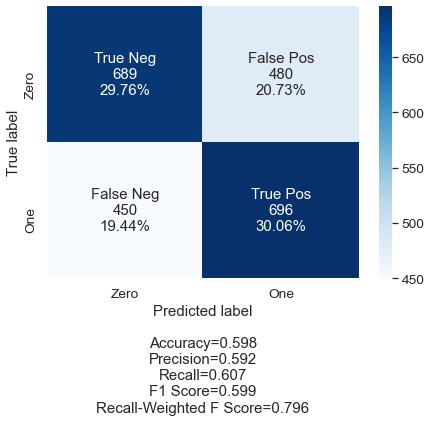

In [36]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

## Decision Tree

In [37]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5) 
tree_clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=5)

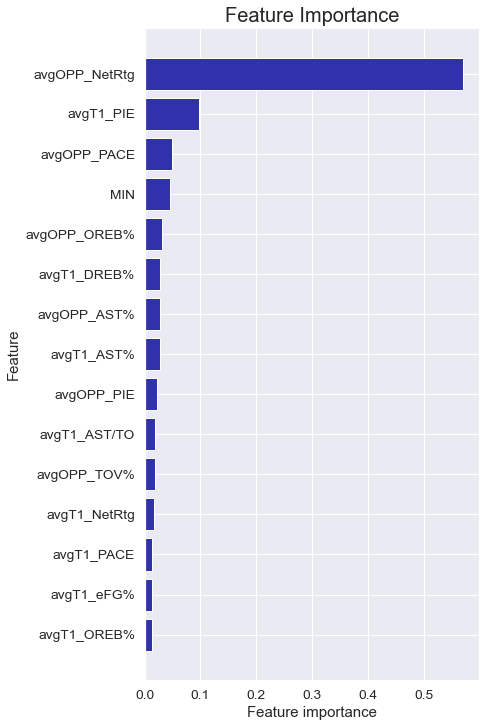

In [38]:
def plot_feature_importances(model):
    n_features = X_train_resampled.shape[1]
    imp_df = pd.DataFrame(model.feature_importances_)
    nm_df = pd.DataFrame(X_train_resampled.columns.values) 
    imp_feats = pd.merge(nm_df, imp_df, left_index=True, right_index=True)
    imp_feats= imp_feats.round(3)
    imp_feats= imp_feats.rename(columns = {'0_x' : 'Feature', '0_y' : 'Importance' })
    imp_feats = imp_feats.loc[imp_feats['Importance'] > .01]
    imp_feats = imp_feats.sort_values('Importance', ascending = True)
    n_features = imp_feats.shape[0]
    plt.figure(figsize=(6, 12))
    plt.barh(range(n_features), imp_feats['Importance'], align='center', color = bluez) 
    plt.yticks(np.arange(n_features), imp_feats['Feature'].values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance', fontsize = 20)

plot_feature_importances(tree_clf)

In [39]:
# Test set predictions
pred = tree_clf.predict(X_all_test)
cf_matrix = confusion_matrix(y_test, pred)

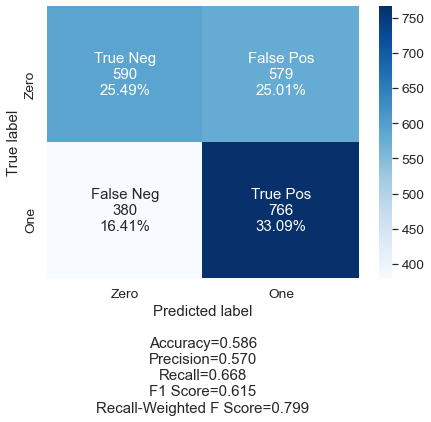

In [40]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [41]:
model_sum = update_results(cf_matrix, 'Decision Tree')
model_sum

KeyError: 'accuracy'

AUC: 0.585677187136572


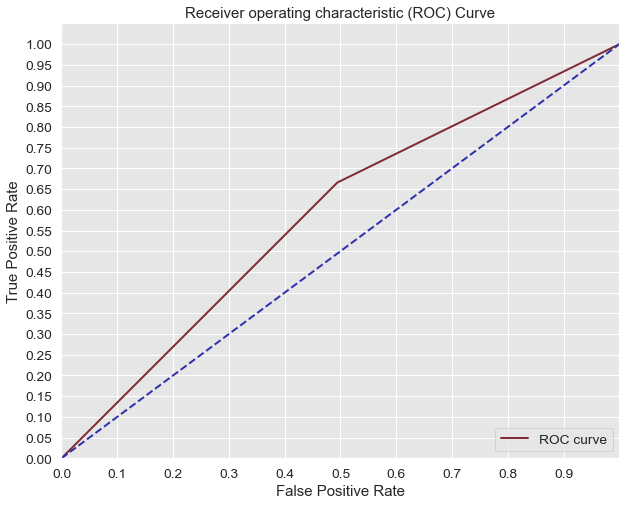

In [ ]:
# Plot ROC
fpr, tpr, thresholds = roc_curve(y_test, pred)
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
print('AUC: {}'.format(auc(fpr, tpr)))                    # Print AUC
plt.figure(figsize=(10, 8))                               # Plot the ROC curve
lw = 2 
plt.plot(fpr, tpr, color=redz, 
            lw=lw, label='ROC curve') 
plt.plot([0, 1], [0, 1], color=bluez, lw=lw, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)]) 
plt.xticks([i/10.0 for i in range(10)])
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right') 
plt.show()

### RandomSearch

In [ ]:
tree_clf.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [ ]:
params = {'max_depth': np.arange(2,10,1),
           'min_samples_leaf': np.arange(0, 5, 1),
           'min_impurity_decrease': np.arange(0,2,.5),
           'ccp_alpha' : np.arange(0,3, 0.5),
           'criterion': ['gini', 'entropy']
}

rand_clf = RandomizedSearchCV(tree_clf,param_distributions=params, n_iter=30,scoring= class_metric)

rand_clf.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(estimator=DecisionTreeClassifier(max_depth=5), n_iter=30,
                   param_distributions={'ccp_alpha': array([0. , 0.5, 1. , 1.5, 2. , 2.5]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_impurity_decrease': array([0. , 0.5, 1. , 1.5]),
                                        'min_samples_leaf': array([0, 1, 2, 3, 4])},
                   scoring='accuracy')

In [ ]:
rand_clf.best_params_

{'min_samples_leaf': 4,
 'min_impurity_decrease': 0.0,
 'max_depth': 8,
 'criterion': 'entropy',
 'ccp_alpha': 0.0}

In [ ]:
pred = rand_clf.predict(X_all_test)
cf_matrix = confusion_matrix(y_test, pred)

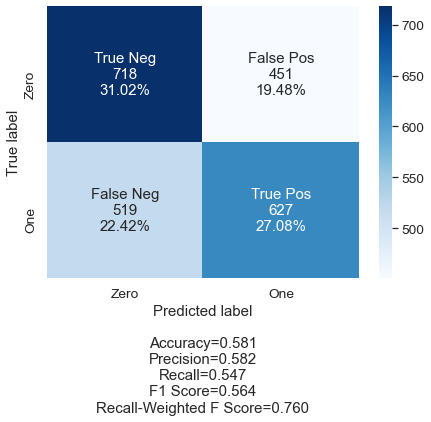

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'Decision Tree -- Random Search')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.796,0.599,0.607,0.592,0.598
1,Decision Tree,0.797,0.614,0.666,0.569,0.585
2,Decision Tree -- Random Search,0.760,0.564,0.547,0.582,0.581


## Random Forest Model

In [ ]:
# fit a RandomForest
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=5)

In [ ]:
forest.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [ ]:
# Training accuracy score
forest.score(X_train_resampled, y_train_resampled)
# Test accuracy score
forest.score(X_all_test, y_test).round(2)

0.59

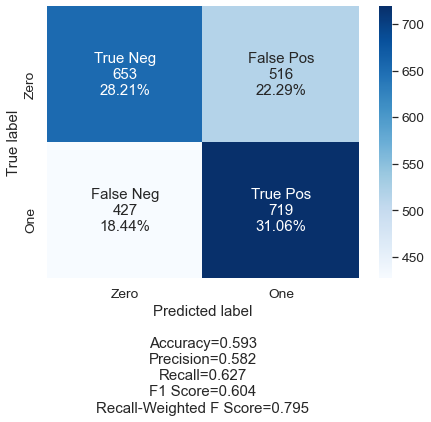

In [ ]:

pred = forest.predict(X_all_test) 
cf_matrix = confusion_matrix(y_test, pred) 

#plot Confusion Matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')


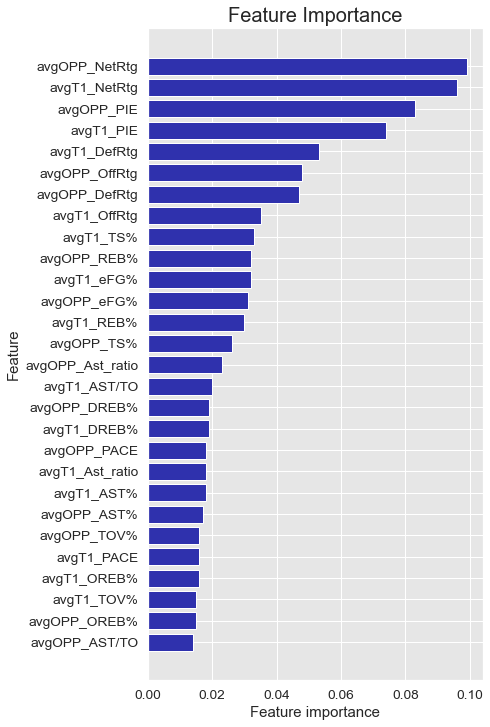

In [ ]:
plot_feature_importances(forest)

In [ ]:
model_sum = update_results(cf_matrix, 'Random Forest')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.796,0.599,0.607,0.592,0.598
1,Decision Tree,0.797,0.614,0.666,0.569,0.585
2,Decision Tree -- Random Search,0.760,0.564,0.547,0.582,0.581
3,Random Forest,0.795,0.604,0.627,0.582,0.593


### GridSearchCV with Random Forest Model #1

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth' : [4,5,6],
}

In [ ]:
# 12 minute runtime
CV_rfc = GridSearchCV(forest, param_grid=param_grid, cv= 5, scoring= class_metric)
CV_rfc.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_depth=5),
             param_grid={'max_depth': [4, 5, 6], 'n_estimators': [100, 200]},
             scoring='accuracy')

In [ ]:
CV_rfc.best_params_

{'max_depth': 4, 'n_estimators': 100}

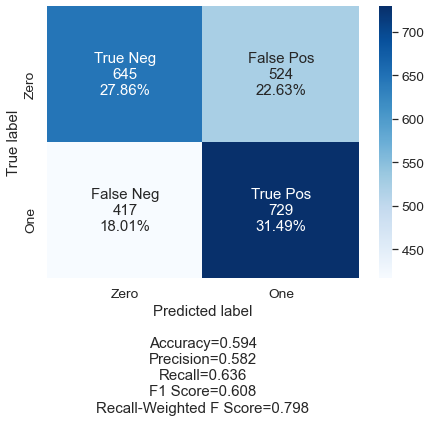

In [ ]:
pred = CV_rfc.predict(X_all_test) 
cf_matrix = confusion_matrix(y_test, pred) 

#plot Confusion Matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'Random Forest -- GridSearch')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.796,0.599,0.607,0.592,0.598
1,Decision Tree,0.797,0.614,0.666,0.569,0.585
2,Decision Tree -- Random Search,0.760,0.564,0.547,0.582,0.581
3,Random Forest,0.795,0.604,0.627,0.582,0.593
4,Random Forest -- GridSearch,0.798,0.608,0.636,0.582,0.594


### RandomizedSearchCV with Random Forest

In [ ]:
rs_param = {'criterion' : ['gini', 'entropy'],
          'bootstrap':[True],
          'n_estimators': [50, 100, 150],
          'max_depth': [5, 6, 7, 8],
          'min_samples_leaf': [0, 1,2,3],
          'min_samples_split':[0, 2,4,6,8],
          }

In [ ]:
# 25Min Runtime

r_search = RandomizedSearchCV(forest, n_jobs = -1, n_iter = 35, 
                                param_distributions = rs_param, 
                                scoring= class_metric)
r_search.fit(X_train_resampled, y_train_resampled)
r_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_depth': 6,
 'criterion': 'gini',
 'bootstrap': True}

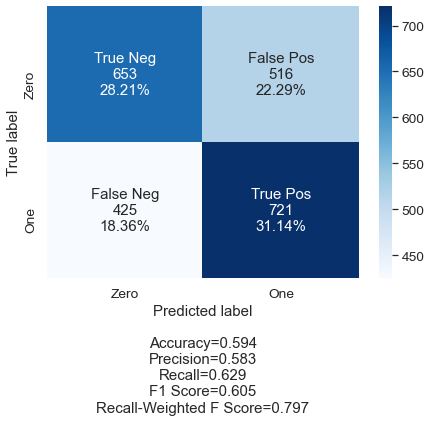

In [ ]:
pred = r_search.predict(X_all_test) 
cf_matrix = confusion_matrix(y_test, pred) 

#plot Confusion Matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'Random Forest -- RandomizedSearch')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.796,0.599,0.607,0.592,0.598
1,Decision Tree,0.797,0.614,0.666,0.569,0.585
2,Decision Tree -- Random Search,0.760,0.564,0.547,0.582,0.581
3,Random Forest,0.795,0.604,0.627,0.582,0.593
4,Random Forest -- GridSearch,0.798,0.608,0.636,0.582,0.594
5,Random Forest -- RandomizedSearch,0.797,0.605,0.629,0.583,0.594


## XGBOOST Model

In [ ]:
# Instantiate XGBClassifier
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train_resampled, y_train_resampled)

# Predict on training and test sets
training_preds = clf.predict(X_train_resampled)
test_preds = clf.predict(X_all_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train_resampled, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)


In [ ]:
cf_matrix = confusion_matrix(y_test, test_preds)

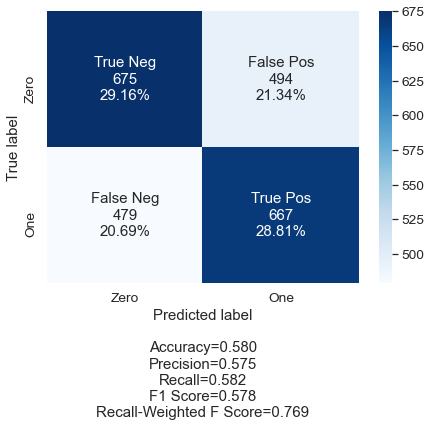

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'XGBoost')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.796,0.599,0.607,0.592,0.598
1,Decision Tree,0.797,0.614,0.666,0.569,0.585
2,Decision Tree -- Random Search,0.760,0.564,0.547,0.582,0.581
3,Random Forest,0.795,0.604,0.627,0.582,0.593
4,Random Forest -- GridSearch,0.798,0.608,0.636,0.582,0.594
5,Random Forest -- RandomizedSearch,0.797,0.605,0.629,0.583,0.594
6,XGBoost,0.769,0.578,0.582,0.575,0.580


### Tune XGBoost

In [ ]:
param_grid = {
    'max_depth': [3,4,5,6]
}

Grid Search found the following optimal parameters: 
max_depth: 3


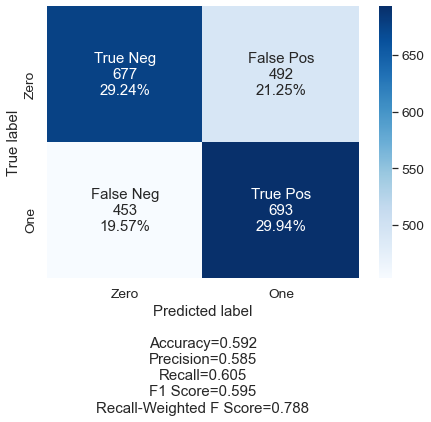

In [ ]:
# Run XGBoost Model
grid_clf = GridSearchCV(clf, param_grid, scoring= class_metric, cv=None, n_jobs=1) 
grid_clf.fit(X_train_resampled, y_train_resampled)
best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_resampled)
test_preds = grid_clf.predict(X_all_test)
training_accuracy = accuracy_score(y_train_resampled, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

#Plot Confusion Matrix
cf_matrix = confusion_matrix(y_test, test_preds)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')


In [ ]:
best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
max_depth: 3


In [ ]:
model_sum = update_results(cf_matrix, 'XGBoost GridSearch')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.796,0.599,0.607,0.592,0.598
1,Decision Tree,0.797,0.614,0.666,0.569,0.585
2,Decision Tree -- Random Search,0.760,0.564,0.547,0.582,0.581
3,Random Forest,0.795,0.604,0.627,0.582,0.593
4,Random Forest -- GridSearch,0.798,0.608,0.636,0.582,0.594
5,Random Forest -- RandomizedSearch,0.797,0.605,0.629,0.583,0.594
6,XGBoost,0.769,0.578,0.582,0.575,0.580
7,XGBoost GridSearch,0.788,0.595,0.605,0.585,0.592


### XGBoost Tuning Round 2
To continue to check scales

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4,6],
    'min_child_weight': [1, 2],
    'subsample': [0.5],
}

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 4
min_child_weight: 2
subsample: 0.5


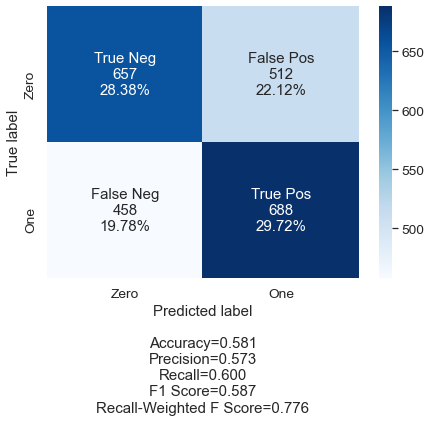

In [ ]:
# 11 min runtime
grid_clf = GridSearchCV(clf, param_grid, scoring= class_metric, cv=None, n_jobs=1) #Using AUC to score
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_resampled)
test_preds = grid_clf.predict(X_all_test)
training_accuracy = accuracy_score(y_train_resampled, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

#Plot Confusion Matrix
cf_matrix = confusion_matrix(y_test, test_preds)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')


In [ ]:
model_sum = update_results(cf_matrix, 'XGBoost GridSearch_2')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.796,0.599,0.607,0.592,0.598
1,Decision Tree,0.797,0.614,0.666,0.569,0.585
2,Decision Tree -- Random Search,0.760,0.564,0.547,0.582,0.581
3,Random Forest,0.795,0.604,0.627,0.582,0.593
4,Random Forest -- GridSearch,0.798,0.608,0.636,0.582,0.594
5,Random Forest -- RandomizedSearch,0.797,0.605,0.629,0.583,0.594
6,XGBoost,0.769,0.578,0.582,0.575,0.580
7,XGBoost GridSearch,0.788,0.595,0.605,0.585,0.592
8,XGBoost GridSearch_2,0.776,0.587,0.600,0.573,0.581


### XGBoost with Randomized Search

In [ ]:
# 20 min runtime
params = { 'max_depth': [3, 4, 5, 6],
           'learning_rate': [ 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 0.7),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100],
           }

rand_clf = RandomizedSearchCV(clf,param_distributions=params, n_iter=25,scoring= class_metric)
rand_clf.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=0,
                                           num_paralle...
                                           reg_alpha=0, reg_lambda=1,
                                           scale_pos_weight=1, subsample=1,
          

Grid Search found the following optimal parameters: 
colsample_bylevel: 0.8999999999999999
colsample_bytree: 0.4
learning_rate: 0.1
max_depth: 3
n_estimators: 100
subsample: 0.5


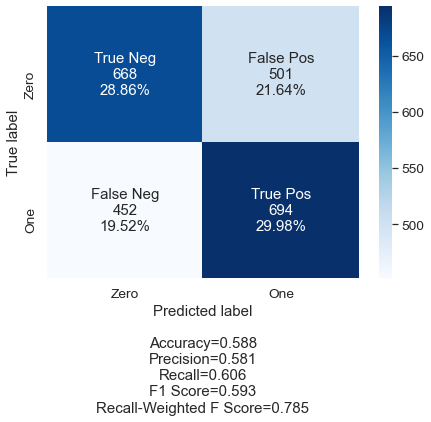

In [ ]:
best_parameters = rand_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = rand_clf.predict(X_train_resampled)
test_preds = rand_clf.predict(X_all_test)

#Plot Confusion Matrix
cf_matrix = confusion_matrix(y_test, test_preds)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'XGBoost RandomizedSearch')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.796,0.599,0.607,0.592,0.598
1,Decision Tree,0.797,0.614,0.666,0.569,0.585
2,Decision Tree -- Random Search,0.760,0.564,0.547,0.582,0.581
3,Random Forest,0.795,0.604,0.627,0.582,0.593
4,Random Forest -- GridSearch,0.798,0.608,0.636,0.582,0.594
5,Random Forest -- RandomizedSearch,0.797,0.605,0.629,0.583,0.594
6,XGBoost,0.769,0.578,0.582,0.575,0.580
7,XGBoost GridSearch,0.788,0.595,0.605,0.585,0.592
8,XGBoost GridSearch_2,0.776,0.587,0.600,0.573,0.581
9,XGBoost RandomizedSearch,0.785,0.593,0.606,0.581,0.588


## Bagged Trees (Ensemble)

In [ ]:
# Instantiate a BaggingClassifier
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

In [ ]:
# Fit to the training data
bagged_tree.fit(X_train_resampled, y_train_resampled)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

In [ ]:
pred = bagged_tree.predict(X_all_test)
cf_matrix = confusion_matrix(y_test, pred)

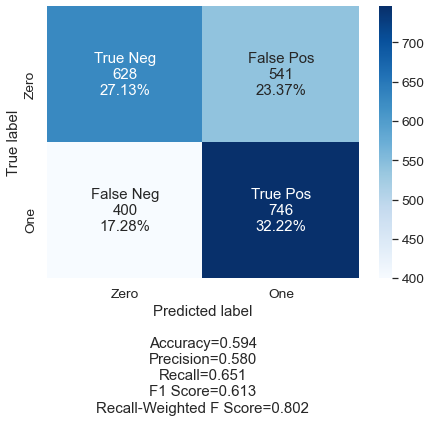

In [ ]:
#  Plot the Confusion Matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'Bagged Tree')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.796,0.599,0.607,0.592,0.598
1,Decision Tree,0.797,0.614,0.666,0.569,0.585
2,Decision Tree -- Random Search,0.760,0.564,0.547,0.582,0.581
3,Random Forest,0.795,0.604,0.627,0.582,0.593
4,Random Forest -- GridSearch,0.798,0.608,0.636,0.582,0.594
5,Random Forest -- RandomizedSearch,0.797,0.605,0.629,0.583,0.594
6,XGBoost,0.769,0.578,0.582,0.575,0.580
7,XGBoost GridSearch,0.788,0.595,0.605,0.585,0.592
8,XGBoost GridSearch_2,0.776,0.587,0.600,0.573,0.581
9,XGBoost RandomizedSearch,0.785,0.593,0.606,0.581,0.588


## Extra Trees

In [ ]:
# fit
ExTrees = ExtraTreesClassifier(n_estimators=100, max_depth= 5)
ExTrees.fit(X_train_resampled, y_train_resampled)

ExtraTreesClassifier(max_depth=5)

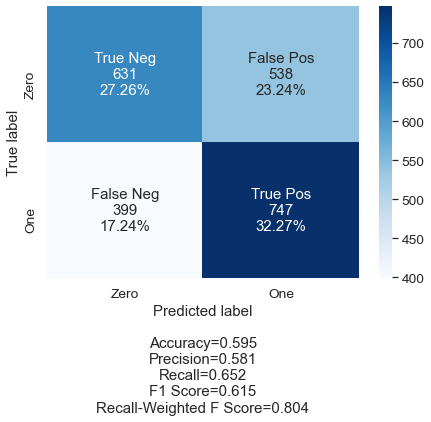

In [ ]:
pred = ExTrees.predict(X_all_test) 
cf_matrix = confusion_matrix(y_test, pred) 

#plot Confusion Matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'Extra Trees')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.796,0.599,0.607,0.592,0.598
1,Decision Tree,0.797,0.614,0.666,0.569,0.585
2,Decision Tree -- Random Search,0.760,0.564,0.547,0.582,0.581
3,Random Forest,0.795,0.604,0.627,0.582,0.593
4,Random Forest -- GridSearch,0.798,0.608,0.636,0.582,0.594
5,Random Forest -- RandomizedSearch,0.797,0.605,0.629,0.583,0.594
6,XGBoost,0.769,0.578,0.582,0.575,0.580
7,XGBoost GridSearch,0.788,0.595,0.605,0.585,0.592
8,XGBoost GridSearch_2,0.776,0.587,0.600,0.573,0.581
9,XGBoost RandomizedSearch,0.785,0.593,0.606,0.581,0.588


In [ ]:
ExTrees.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Extra Trees with RandomSearchCV

In [ ]:
params = { 'max_depth': [ 3, 4, 5, 6],
           'min_impurity_decrease': np.arange(0.0, 1.0, 0.2),
           'min_samples_leaf': np.arange(0, 4, 1),
           'min_samples_split': np.arange(0,6,1),
           'verbose': np.arange(0,3,1),
           'ccp_alpha': np.arange(0,4,1)
           }

ET_clf = RandomizedSearchCV(ExTrees,param_distributions=params,n_jobs= -1, n_iter=50, scoring= class_metric)
ET_clf.fit(X_train_resampled, y_train_resampled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomizedSearchCV(estimator=ExtraTreesClassifier(max_depth=5), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'ccp_alpha': array([0, 1, 2, 3]),
                                        'max_depth': [3, 4, 5, 6],
                                        'min_impurity_decrease': array([0. , 0.2, 0.4, 0.6, 0.8]),
                                        'min_samples_leaf': array([0, 1, 2, 3]),
                                        'min_samples_split': array([0, 1, 2, 3, 4, 5]),
                                        'verbose': array([0, 1, 2])},
                   scoring='accuracy')

Grid Search found the following optimal parameters: 
ccp_alpha: 0
max_depth: 6
min_impurity_decrease: 0.0
min_samples_leaf: 3
min_samples_split: 3
verbose: 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


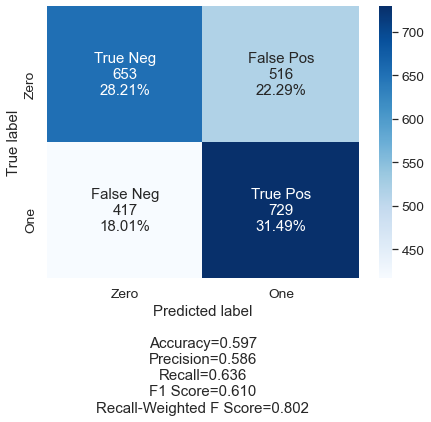

In [ ]:
best_parameters = ET_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = ET_clf.predict(X_train_resampled)
test_preds = ET_clf.predict(X_all_test)

#Plot Confusion Matrix
cf_matrix = confusion_matrix(y_test, test_preds)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'Extra Trees -- RandomizedSearch')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.796,0.599,0.607,0.592,0.598
1,Decision Tree,0.797,0.614,0.666,0.569,0.585
2,Decision Tree -- Random Search,0.760,0.564,0.547,0.582,0.581
3,Random Forest,0.795,0.604,0.627,0.582,0.593
4,Random Forest -- GridSearch,0.798,0.608,0.636,0.582,0.594
5,Random Forest -- RandomizedSearch,0.797,0.605,0.629,0.583,0.594
6,XGBoost,0.769,0.578,0.582,0.575,0.580
7,XGBoost GridSearch,0.788,0.595,0.605,0.585,0.592
8,XGBoost GridSearch_2,0.776,0.587,0.600,0.573,0.581
9,XGBoost RandomizedSearch,0.785,0.593,0.606,0.581,0.588


## KNN

In [ ]:
# Running takes 9 minutes
knclf = KNeighborsClassifier()

# Fit 
knclf.fit(X_train_resampled, y_train_resampled)

# Predict
test_preds = knclf.predict(X_all_test)

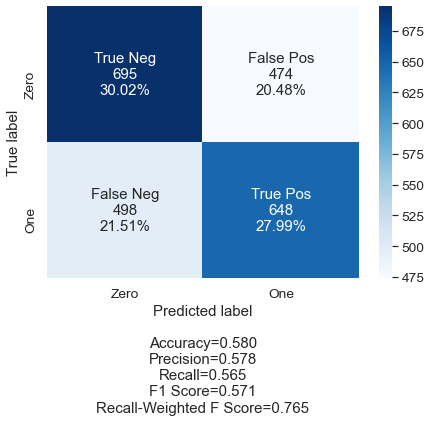

In [ ]:
cf_matrix = confusion_matrix(y_test, test_preds)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'KNN')
model_sum


,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.796,0.599,0.607,0.592,0.598
1,Decision Tree,0.797,0.614,0.666,0.569,0.585
2,Decision Tree -- Random Search,0.760,0.564,0.547,0.582,0.581
3,Random Forest,0.795,0.604,0.627,0.582,0.593
4,Random Forest -- GridSearch,0.798,0.608,0.636,0.582,0.594
5,Random Forest -- RandomizedSearch,0.797,0.605,0.629,0.583,0.594
6,XGBoost,0.769,0.578,0.582,0.575,0.580
7,XGBoost GridSearch,0.788,0.595,0.605,0.585,0.592
8,XGBoost GridSearch_2,0.776,0.587,0.600,0.573,0.581
9,XGBoost RandomizedSearch,0.785,0.593,0.606,0.581,0.588


## SVC (Support Vector Classification)

In [ ]:
from sklearn.svm import SVC

In [ ]:

svclf = SVC()

# Fit 
svclf.fit(X_train_resampled, y_train_resampled)

# Predict
test_preds = svclf.predict(X_all_test)

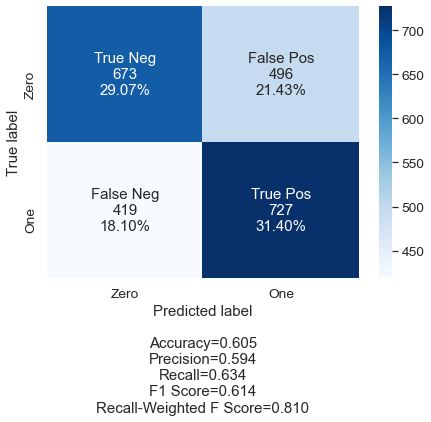

In [ ]:
cf_matrix = confusion_matrix(y_test, test_preds)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'SVC')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.796,0.599,0.607,0.592,0.598
1,Decision Tree,0.797,0.614,0.666,0.569,0.585
2,Decision Tree -- Random Search,0.760,0.564,0.547,0.582,0.581
3,Random Forest,0.795,0.604,0.627,0.582,0.593
4,Random Forest -- GridSearch,0.798,0.608,0.636,0.582,0.594
5,Random Forest -- RandomizedSearch,0.797,0.605,0.629,0.583,0.594
6,XGBoost,0.769,0.578,0.582,0.575,0.580
7,XGBoost GridSearch,0.788,0.595,0.605,0.585,0.592
8,XGBoost GridSearch_2,0.776,0.587,0.600,0.573,0.581
9,XGBoost RandomizedSearch,0.785,0.593,0.606,0.581,0.588


## Results

## Conclusion

SVC wins with a .605. DAMN! Lets improve on this. 